In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
from attacksplitnn.splitnn import Client, Server, SplitNN
from attacksplitnn.attack import IntermidiateLevelAttack

In [3]:
epsilons = [.15]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [7]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826


In [8]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
# LeNet Model definition
class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        return x

In [10]:
# LeNet Model definition
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [19]:
model_1 = FirstNet()
model_1 = model_1.to(device)

model_2 = SecondNet()
model_2 = model_2.to(device)

opt_1 = optim.Adam(model_1.parameters(), lr=1e-3)
opt_2 = optim.Adam(model_2.parameters(), lr=1e-3)

criterion = F.nll_loss

client = Client(model_1)
server = Server(model_2)

splitnn = SplitNN(client, server, opt_1, opt_2)

In [139]:
ila = IntermidiateLevelAttack(splitnn, 50, 1e-3, 1, 1, with_projection=False)

In [140]:
len(examples)

1

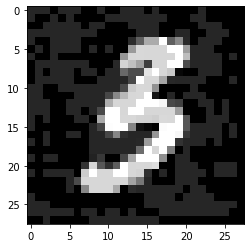

In [141]:
adversarial_example = examples[0][2][2]
plt.imshow(adversarial_example, cmap="gray")

In [142]:
for data in test_loader:
    x, y = data[0], data[1]
    if y == 3:
        break

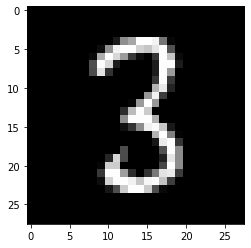

In [143]:
plt.imshow(x.reshape(28, 28), cmap="gray")

In [145]:
improved_adversarial_example =\
    ila.attack(x, torch.tensor(adversarial_example).reshape(1, 1, 28, 28))

improved_adversarial_example =\
    ila.attack(torch.tensor(adversarial_example).reshape(1, 1, 28, 28), x)

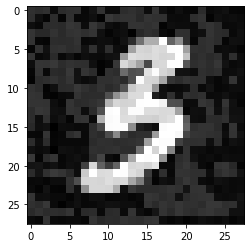

In [146]:
plt.imshow(improved_adversarial_example.detach().numpy().reshape(28, 28), cmap="gray")

In [147]:
model(x)

tensor([[-8.0016, -5.0808, -4.1517, -0.0679, -8.1131, -4.8153, -8.3362, -5.5408,
         -3.5832, -5.8028]], grad_fn=<LogSoftmaxBackward>)

In [148]:
model(improved_adversarial_example)

tensor([[-3.1003, -3.8773, -4.5547, -1.9725, -3.3248, -0.7117, -2.5853, -3.9320,
         -2.8939, -2.2301]], grad_fn=<LogSoftmaxBackward>)

In [149]:
model(torch.Tensor(adversarial_example).reshape(1, 1, 28, 28))

tensor([[-3.0737, -3.8313, -4.5290, -1.9934, -3.3056, -0.7170, -2.5315, -3.9196,
         -2.8853, -2.2543]], grad_fn=<LogSoftmaxBackward>)